# Small World Propensity exploration for time evolving Kuramoto model

Content:
- First implement known SWP for pairwise case
- Explore high order extension of the SWP, from high order clustering and pathlength
- Compare for xgi_kuramoto model, starting with 0 HOI and increasing high order interactions

In [1]:
import infotopo_no_prints
import os
import xgi
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.animation as animation
from sklearn.utils import Bunch
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Normalize the first two columns individually for a given dataframe (range 0-1)
def normalize_columns(df):
    # Normalize first column (index 0)
    min_x, max_x = df.iloc[:, 0].min(), df.iloc[:, 0].max()
    df.iloc[:, 0] = (df.iloc[:, 0] - min_x) / (max_x - min_x) if max_x != min_x else 0
    
    # Normalize second column (index 1)
    min_y, max_y = df.iloc[:, 1].min(), df.iloc[:, 1].max()
    df.iloc[:, 1] = (df.iloc[:, 1] - min_y) / (max_y - min_y) if max_y != min_y else 0
    
    return df

# Optimized function to compute TSE complexity
def compute_tse_complexity(TC_dict):
    """
    Computes the TSE complexity given a dictionary of total correlations.
    
    Parameters:
        TC_dict (dict): Dictionary of total correlations where keys are tuples (subsets).
        
    Returns:
        float: The TSE complexity.
    """
    N = max(len(subset) for subset in TC_dict)  # Maximum subset size
    TSE = 0
    for gamma in range(1, N):
        TC_full = (gamma / N) * TC_dict[tuple(range(1, N + 1))]
        E_TC_gamma = np.mean([TC_dict[subset] for subset in TC_dict if len(subset) == gamma])
        TSE += TC_full - E_TC_gamma
    return TSE

# Convert pandas dataframe to bunch object
def dataframe_to_bunch(dataframe, target=None, feature_names=None, target_names=None, descr="Custom dataset"):
    if feature_names is None:
        feature_names = dataframe.columns.tolist()
    
    return Bunch(
        data=dataframe.to_numpy(),
        target=target if target is not None else np.zeros(dataframe.shape[0]),
        feature_names=feature_names,
        target_names=target_names if target_names is not None else ["target"],
        DESCR=descr
    )

# Obtain topological information metrics using infotopo
def obtain_infotopo_metrics(dataset, dimension_max=0, dimension_tot=0):

    if dimension_max == 0:
        dimension_max = 3 #dataset.shape[1]
    if dimension_tot == 0:
        dimension_tot = 9 #dataset.shape[1]
    
    sample_size = dataset.shape[0]
    nb_of_values = 16
    forward_computation_mode = True
    work_on_transpose = False
    supervised_mode = False
    sampling_mode = 1
    deformed_probability_mode = False

    information_topo = infotopo_no_prints.infotopo(dimension_max = dimension_max,
                                dimension_tot = dimension_tot,
                                sample_size = sample_size,
                                work_on_transpose = work_on_transpose,
                                nb_of_values = nb_of_values,
                                sampling_mode = sampling_mode,
                                deformed_probability_mode = deformed_probability_mode,
                                supervised_mode = supervised_mode,
                                forward_computation_mode = forward_computation_mode)
    
    Nentropie = information_topo.simplicial_entropies_decomposition(dataset)
    Ninfomut = information_topo.simplicial_infomut_decomposition(Nentropie)
    Nfree_energy = information_topo.total_correlation_simplicial_lanscape(Nentropie)
    
    return  Nentropie, Ninfomut, Nfree_energy

# Function to compute metrics for a time window sliding over a given timeseries
def interactions_values_relative(df_input, window_size=0, window_step=0, dimension_max=0, dimension_tot=0):
    # Initialize an empty DataFrame
    columns = ['R_sum', 'S_sum', 'TSE_value', 'R_std', 'S_std']
    df_output = pd.DataFrame(columns=columns)

    # Set initial window conditions
    if window_size == 0:
        window_size = len(df_input)-1
    if window_step == 0:
        window_step = 1
    window_start = 0
    window_end = window_start + window_size

    while window_end < len(df_input):
        bunch_data = dataframe_to_bunch(df_input.iloc[window_start:window_end])
        Nentropie, Ninfomut, Nfree_energy = obtain_infotopo_metrics(bunch_data.data, dimension_max, dimension_tot)

        S_values = [(TC - MI) / 2 for TC, MI in zip(Nfree_energy.values(), Ninfomut.values())]
        R_values = [(TC + MI) / 2 for TC, MI in zip(Nfree_energy.values(), Ninfomut.values())]
        S_std = np.std(S_values, ddof=1)
        R_std = np.std(R_values, ddof=1)
        S_sum = sum(S_values)
        R_sum = sum(R_values)
        TSE_value = compute_tse_complexity(Nfree_energy)

        # Add the new values to the dataframe
        new_row = pd.DataFrame({'R_sum': [R_sum], 'S_sum': [S_sum], 'TSE_value': [TSE_value], 'R_std': [R_std], 'S_std':[S_std]})
        df_output = pd.concat([df_output, new_row], ignore_index=True)
        
        window_start += window_step
        window_end += window_step

    # Normalize all the values so that the S and R values are all positive and the maximum R and S are 1 and minimum 0.
    min_R = df_output.iloc[:, 0].min()
    df_output.iloc[:, 0] += abs(min_R)

    df_output['S_sum'] = (df_output['S_sum'] - df_output['S_sum'].min()) / (df_output['S_sum'].max() - df_output['S_sum'].min())
    df_output['R_sum'] = (df_output['R_sum'] - df_output['R_sum'].min()) / (df_output['R_sum'].max() - df_output['R_sum'].min())

    return df_output

# Kuramoto model differential equation
def kuramoto(t, theta, omega, K, N):
    dtheta = np.zeros(N)
    for i in range(N):
        interaction = np.sum(np.sin(theta - theta[i]))
        dtheta[i] = omega[i] + (K / N) * interaction
    return dtheta

# Simulate the Kuramoto model and save frequency time series
def simulate_kuramoto(N=50, K=2.0, T=20, dt=0.01):
    # Initialize random natural frequencies and initial phases
    omega = np.random.normal(loc=0, scale=1, size=N)
    initial_phases = np.random.uniform(0, 2 * np.pi, N)
    
    # Time vector
    t_eval = np.arange(0, T, dt)
    
    # Solve the system
    sol = solve_ivp(kuramoto, [0, T], initial_phases, args=(omega, K, N), t_eval=t_eval, method='RK45')
    
    # Compute instantaneous frequencies (time derivative of phases)
    frequencies = np.gradient(sol.y, sol.t, axis=1)

    # Convert to right data format
    frequencies_df = pd.DataFrame(frequencies).transpose()
    
    return frequencies_df

# Simulate Kuramoto model for high order interactions with XGI
def simulate_kuramoto_xgi(H, K2, K3, T=20, dt=0.01):
    timesteps=int(T/dt)
    H_int = xgi.convert_labels_to_integers(H, "label")
    links = H_int.edges.filterby("size", 2).members()
    triangles = H_int.edges.filterby("size", 3).members()
    n = H_int.num_nodes

    theta_time = np.zeros((timesteps, n))
    times = np.arange(timesteps) * dt

    omega = np.random.normal(0, 1, n)
    theta = np.random.random(n) * 2 * np.pi

    for t in range(timesteps):
        theta_time[t] = theta
        r1 = np.zeros(n, dtype=complex)
        r2 = np.zeros(n, dtype=complex)

        for i, j in links:
            r1[i] += np.exp(1j * theta[j])
            r1[j] += np.exp(1j * theta[i])

        for i, j, k in triangles:
            r2[i] += np.exp(2j * theta[j] - 1j * theta[k]) + np.exp(2j * theta[k] - 1j * theta[j])
            r2[j] += np.exp(2j * theta[i] - 1j * theta[k]) + np.exp(2j * theta[k] - 1j * theta[i])
            r2[k] += np.exp(2j * theta[i] - 1j * theta[j]) + np.exp(2j * theta[j] - 1j * theta[i])

        d_theta = omega + K2 * np.multiply(r1, np.exp(-1j * theta)).imag + K3 * np.multiply(r2, np.exp(-1j * theta)).imag
        theta_new = theta + d_theta * dt
        theta = theta_new

    frequencies_df = pd.DataFrame(theta_time, index=times)

    return frequencies_df

In [3]:
# Function to compute metrics for a time window sliding over a given timeseries
def interactions_values_relative(df_input, window_size=0, window_step=0, dimension_max=0, dimension_tot=0):
    # Initialize an empty DataFrame
    columns = ['R_sum', 'S_sum', 'TSE_value', 'R_std', 'S_std', 'TC_lists']
    df_output = pd.DataFrame(columns=columns)

    # Set initial window conditions
    if window_size == 0:
        window_size = len(df_input)-1
    if window_step == 0:
        window_step = 1
    window_start = 0
    window_end = window_start + window_size

    while window_end < len(df_input):
        bunch_data = dataframe_to_bunch(df_input.iloc[window_start:window_end])
        Nentropie, Ninfomut, Nfree_energy = obtain_infotopo_metrics(bunch_data.data, dimension_max, dimension_tot)

        S_values = [(TC - MI) / 2 for TC, MI in zip(Nfree_energy.values(), Ninfomut.values())]
        R_values = [(TC + MI) / 2 for TC, MI in zip(Nfree_energy.values(), Ninfomut.values())]
        S_std = np.std(S_values, ddof=1)
        R_std = np.std(R_values, ddof=1)
        S_sum = sum(S_values)
        R_sum = sum(R_values)
        TSE_value = compute_tse_complexity(Nfree_energy)

        # Add the new values to the dataframe
        new_row = pd.DataFrame({'R_sum': [R_sum], 'S_sum': [S_sum], 'TSE_value': [TSE_value], 'R_std': [R_std], 'S_std':[S_std], 'TC_lists':[Ninfomut]})
        df_output = pd.concat([df_output, new_row], ignore_index=True)
        
        window_start += window_step
        window_end += window_step

    # Normalize all the values so that the S and R values are all positive and the maximum R and S are 1 and minimum 0.
    min_R = df_output.iloc[:, 0].min()
    df_output.iloc[:, 0] += abs(min_R)

    df_output['S_sum'] = (df_output['S_sum'] - df_output['S_sum'].min()) / (df_output['S_sum'].max() - df_output['S_sum'].min())
    df_output['R_sum'] = (df_output['R_sum'] - df_output['R_sum'].min()) / (df_output['R_sum'].max() - df_output['R_sum'].min())

    return df_output

In [15]:
# Parameters
N = 8   # Number of oscillators
K = 3.0  # Coupling strength
T = 20   # Total time
dt = 0.01  # Time step

# Construct an all-to-all pairwise hypergraph (equivalent to a complete graph)
H = xgi.Hypergraph()
H.add_nodes_from(range(N))  # Add nodes
for i in range(N):
    for j in range(i + 1, N):
        H.add_edge([i, j])  # Add all possible pairwise links

# Set k2 = K / N for consistency with the standard Kuramoto model
K2 = K / N
K3 = 0  # Higher-order interactions

# Run the simulation
frequencies_df = simulate_kuramoto_xgi(H, K2, K3, T, dt)
# frequencies_df = simulate_kuramoto(N, K, T, dt)

In [16]:
# Obtain information metrics
window_size = 1000
window_step = 10
dimension_max = 8
dimension_tot = 8

df_oscillators = interactions_values_relative(frequencies_df, window_size, window_step, dimension_max, dimension_tot)

C:\Users\cyril\AppData\Local\Temp\ipykernel_9556\914995518.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


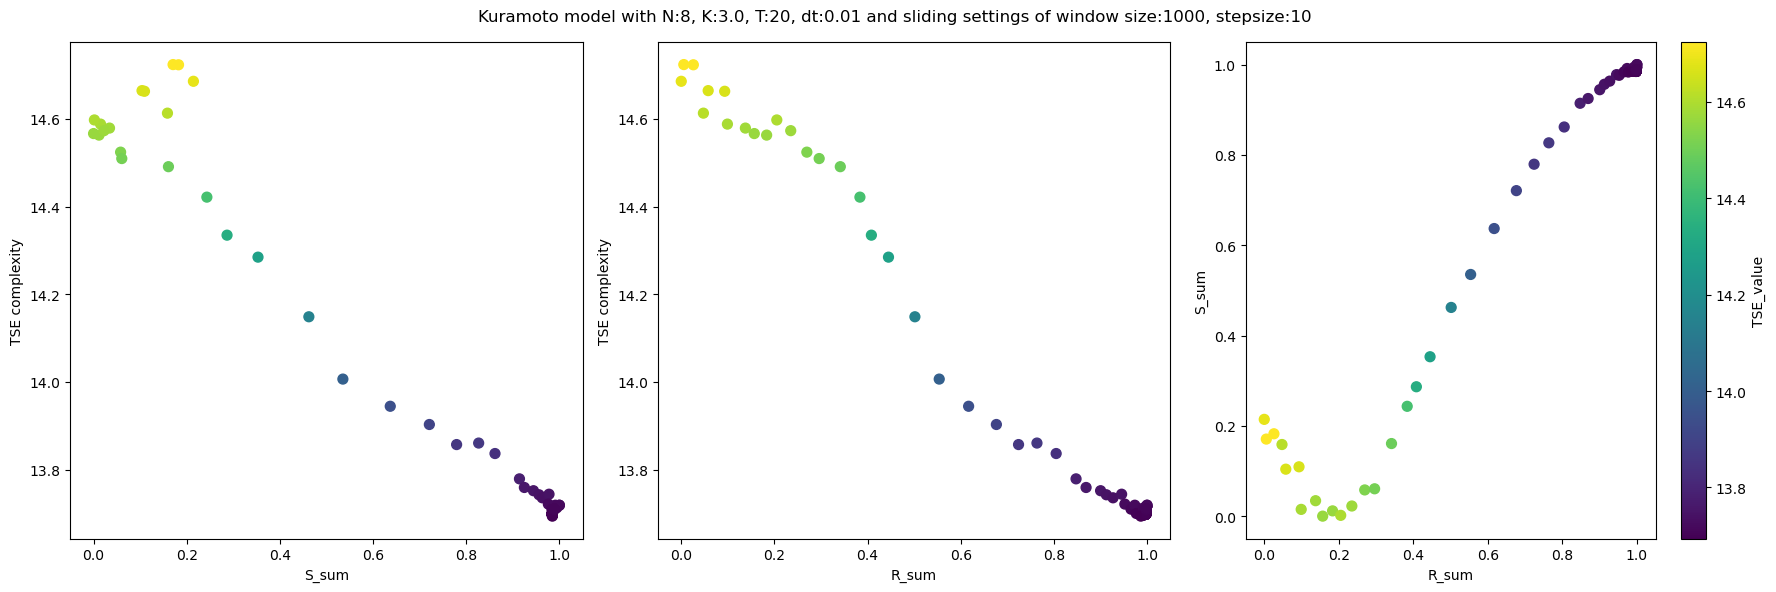

In [17]:
# Create a figure with 1 row and 3 columns for subplots
df = df_oscillators
plt.figure(figsize=(18, 6))

# First subplot for Synergy path
plt.subplot(1, 3, 1)
plt.scatter(df['S_sum'], df['TSE_value'], c=df['TSE_value'], cmap='viridis', s=50)
# for i, (x, y) in enumerate(zip(df['S_sum'], df['TSE_value']), 1):
#    plt.text(x, y, f'c{i}', fontsize=12, ha='right')
plt.xlabel('S_sum')
plt.ylabel('TSE complexity')

# Second subplot for Redundancy path
plt.subplot(1, 3, 2)
plt.scatter(df['R_sum'], df['TSE_value'], c=df['TSE_value'], cmap='viridis', s=50)
#for i, (x, y) in enumerate(zip(df['R_sum'], df['TSE_value']), 1):
#    plt.text(x, y, f'c{i}', fontsize=12, ha='right')
plt.xlabel('R_sum')
plt.ylabel('TSE complexity')

# Third subplot for Redundancy vs Synergy path
plt.subplot(1, 3, 3)
plt.scatter(df['R_sum'], df['S_sum'], c=df['TSE_value'], cmap='viridis', s=50)
#for i, (x, y) in enumerate(zip(df['R_sum'], df['S_sum']), 1):
#    plt.text(x, y, f'c{i}', fontsize=12, ha='right')
plt.colorbar(label='TSE_value')
plt.xlabel('R_sum')
plt.ylabel('S_sum')

# Adjust layout to avoid overlap and display the plot
plt.suptitle(f'Kuramoto model with N:{N}, K:{K}, T:{T}, dt:{dt} and sliding settings of window size:{window_size}, stepsize:{window_step}')
plt.tight_layout()
plt.show()


Use quad_clustering computation from (https://github.com/Gyeong-GyunHa/qch/blob/main/README.md) converted to python code from f90

In [ ]:
import numpy as np

def load_inci_list(file_name):
    """ Load incidence list from a file """
    inci_list = np.loadtxt(file_name, dtype=int)
    return inci_list

def inci_list2incmat(n1, n2, inci_list):
    """ Convert incidence list to incidence matrix """
    inci_mat = np.zeros((n1, n2), dtype=bool)

    for edge in range(1, n2 + 1):
        nodes = inci_list[inci_list[:, 1] == edge, 0]
        inci_mat[nodes - 1, edge - 1] = True

    return inci_mat

def quad_clustering(n1, n2, inci_mat):
    """ Compute the quad clustering coefficient """
    clu_coeff = np.zeros(n1)

    for i in range(n1):
        numofedges = np.count_nonzero(inci_mat[i, :])
        if numofedges < 2:
            continue

        edgelist1 = np.where(inci_mat[i, :])[0]

        numerator = 0
        denominator = 0

        for a in range(len(edgelist1) - 1):
            edge_a = edgelist1[a]
            nodes_a = np.where(inci_mat[:, edge_a])[0]

            if len(nodes_a) == 1:
                continue

            for b in range(a + 1, len(edgelist1)):
                edge_b = edgelist1[b]
                nodes_b = np.where(inci_mat[:, edge_b])[0]

                if len(nodes_b) == 1:
                    continue

                denominator += min(len(nodes_a) - 1, len(nodes_b) - 1)

                common_nodes = np.intersect1d(nodes_a, nodes_b)
                numerator += len(common_nodes) - (i in common_nodes)

        if denominator > 0:
            clu_coeff[i] = numerator / denominator

    return clu_coeff

def main():
    input_file = "Data\\sample_hypergraph.txt"
    output_file = "Data\\quadclustering_dist.txt"

    # Load incidence list
    inci_list = load_inci_list(input_file)
    n1 = np.max(inci_list[:, 0])
    n2 = np.max(inci_list[:, 1])

    # Convert to incidence matrix
    inci_mat = inci_list2incmat(n1, n2, inci_list)

    # Compute clustering coefficients
    quad_clu_coeff = quad_clustering(n1, n2, inci_mat)
    print(quad_clu_coeff)

    # Save results
    np.savetxt(output_file, quad_clu_coeff)

if __name__ == "__main__":
    main()


5 4
[[ True  True False False]
 [ True False  True False]
 [ True  True  True False]
 [ True  True False  True]
 [False False  True  True]]
[1.  0.5 0.5 0.5 0. ]


Adjust the quad_clustering code to a weighted version, i.e. to apply on weighted hypergraphs.

In [63]:
def load_inci_list(file_name):
    """ Load weighted incidence list from a file (node, hyperedge, weight) """
    inci_list = np.loadtxt(file_name, dtype=int)
    return inci_list

def inci_list2incmat(n1, n2, inci_list):
    """ Convert weighted incidence list to incidence matrix """
    inci_mat = np.zeros((n1, n2), dtype=float)

    for node, edge, weight in inci_list:
        inci_mat[node - 1, edge - 1] = weight  # Store weight in the matrix

    return inci_mat

def quad_clustering(n1, n2, inci_mat):
    """ Compute the quad clustering coefficient for a weighted hypergraph """
    clu_coeff = np.zeros(n1)

    for i in range(n1):
        edge_weights = inci_mat[i, :]
        numofedges = np.count_nonzero(edge_weights)

        if numofedges < 2:
            continue

        edgelist1 = np.where(edge_weights > 0)[0]  # Get edges with nonzero weight

        numerator = 0
        denominator = 0

        for a in range(len(edgelist1) - 1):
            edge_a = edgelist1[a]
            nodes_a = np.where(inci_mat[:, edge_a] > 0)[0]
            weights_a = inci_mat[nodes_a, edge_a]

            if len(nodes_a) == 1:
                continue

            for b in range(a + 1, len(edgelist1)):
                edge_b = edgelist1[b]
                nodes_b = np.where(inci_mat[:, edge_b] > 0)[0]
                weights_b = inci_mat[nodes_b, edge_b]

                if len(nodes_b) == 1:
                    continue

                # Use min(weight) instead of min(count) for weighted clustering
                denominator += min(np.sum(weights_a) - 1, np.sum(weights_b) - 1)

                common_nodes = np.intersect1d(nodes_a, nodes_b)
                if len(common_nodes) > 1:
                    numerator += np.sum(inci_mat[common_nodes, edge_a] * inci_mat[common_nodes, edge_b])

        if denominator > 0:
            clu_coeff[i] = numerator / denominator

    return clu_coeff

def main(input_file):

    # Load weighted incidence list
    inci_list = load_inci_list(input_file)
    n1 = np.max(inci_list[:, 0])
    n2 = np.max(inci_list[:, 1])

    # Convert to weighted incidence matrix
    inci_mat = inci_list2incmat(n1, n2, inci_list)

    # Compute clustering coefficients
    quad_clu_coeff = quad_clustering(n1, n2, inci_mat)

    return np.mean(quad_clu_coeff)

input_file = "Data/sample_hypergraph_weighted_low.txt"
average_high_order_clustering_low = main(input_file)
print('Clustering for low expectation', average_high_order_clustering_low)

input_file = "Data/sample_hypergraph_weighted_mid.txt"
average_high_order_clustering_mid = main(input_file)
print('Clustering for mid expectation', average_high_order_clustering_mid)

input_file = "Data/sample_hypergraph_weighted_high.txt"
average_high_order_clustering_high = main(input_file)
print('Clustering for high expectation', average_high_order_clustering_high)

Clustering for low expectation 0.9575757575757574
Clustering for mid expectation 1.2848484848484847
Clustering for high expectation 2.1142857142857143


Extract necessities from the clustering calculation and adjust so that we can give the desired dictionary as input to represent the hypergraph.

In [64]:
def quad_clustering(hypergraph):
    """ Compute the quad clustering coefficient for a weighted hypergraph """
    # Convert hypergraph to incidence matrix
    # Extract unique vertices
    vertices = sorted(set(v for edge in hypergraph.keys() for v in edge))

    # Extract hyperedges
    hyperedges = list(hypergraph.keys())

    # Create an empty incidence matrix
    inci_mat = np.zeros((len(vertices), len(hyperedges)))

    # Fill in the matrix
    for j, edge in enumerate(hyperedges):
        weight = hypergraph[edge]
        for v in edge:
            i = vertices.index(v)  # Row index for the vertex
            inci_mat[i, j] = weight

    # Compute weighted quad clustering from incidence matrix
    clu_coeff = np.zeros(n1)

    for i in range(n1):
        edge_weights = inci_mat[i, :]
        numofedges = np.count_nonzero(edge_weights)

        if numofedges < 2:
            continue

        edgelist1 = np.where(edge_weights > 0)[0]  # Get edges with nonzero weight

        numerator = 0
        denominator = 0

        for a in range(len(edgelist1) - 1):
            edge_a = edgelist1[a]
            nodes_a = np.where(inci_mat[:, edge_a] > 0)[0]
            weights_a = inci_mat[nodes_a, edge_a]

            if len(nodes_a) == 1:
                continue

            for b in range(a + 1, len(edgelist1)):
                edge_b = edgelist1[b]
                nodes_b = np.where(inci_mat[:, edge_b] > 0)[0]
                weights_b = inci_mat[nodes_b, edge_b]

                if len(nodes_b) == 1:
                    continue

                # Use min(weight) instead of min(count) for weighted clustering
                denominator += min(np.sum(weights_a) - 1, np.sum(weights_b) - 1)

                common_nodes = np.intersect1d(nodes_a, nodes_b)
                if len(common_nodes) > 1:
                    numerator += np.sum(inci_mat[common_nodes, edge_a] * inci_mat[common_nodes, edge_b])

        if denominator > 0:
            clu_coeff[i] = numerator / denominator

    return np.mean(clu_coeff)

Test for an example hypergraph (for now sample_hypergraph_weighted_low). This shows that we obtain the same results as with the incidence matrix method.

In [6]:
# Test
hypergraph = {
    (4, 5): 3,
    (2, 3, 5): 2,
    (1, 3, 4): 2,
    (1, 2, 3, 4): 1,}

%time average_high_order_clustering = quad_clustering(hypergraph)
average_high_order_clustering

CPU times: total: 0 ns
Wall time: 1.99 ms


0.9575757575757574

Improved function?

In [7]:
def quad_clustering(hypergraph):
    """Compute the quad clustering coefficient for a weighted hypergraph."""
    
    # Extract unique vertices and assign indices
    vertices = sorted(set(v for edge in hypergraph for v in edge))
    vertex_index = {v: i for i, v in enumerate(vertices)}

    # Extract hyperedges
    hyperedges = list(hypergraph.keys())

    # Create an incidence matrix
    inci_mat = np.zeros((len(vertices), len(hyperedges)))

    # Fill the incidence matrix
    for j, edge in enumerate(hyperedges):
        weight = hypergraph[edge]
        for v in edge:
            inci_mat[vertex_index[v], j] = weight

    n_vertices = len(vertices)
    clu_coeff = np.zeros(n_vertices)

    # Compute weighted quad clustering coefficient
    for i in range(n_vertices):
        edge_weights = inci_mat[i, :]
        edge_indices = np.nonzero(edge_weights)[0]  # Get indices of hyperedges containing vertex i

        num_edges = len(edge_indices)
        if num_edges < 2:
            continue

        numerator = 0
        denominator = 0

        for a in range(num_edges - 1):
            edge_a = edge_indices[a]
            nodes_a = np.where(inci_mat[:, edge_a] > 0)[0]
            weights_a = inci_mat[nodes_a, edge_a]

            if len(nodes_a) == 1:
                continue

            for b in range(a + 1, num_edges):
                edge_b = edge_indices[b]
                nodes_b = np.where(inci_mat[:, edge_b] > 0)[0]
                weights_b = inci_mat[nodes_b, edge_b]

                if len(nodes_b) == 1:
                    continue

                # Use min(weight sum - 1) for denominator calculation
                denominator += min(np.sum(weights_a) - 1, np.sum(weights_b) - 1)

                # Find common nodes
                common_nodes = np.intersect1d(nodes_a, nodes_b, assume_unique=True)
                if len(common_nodes) > 1:
                    numerator += np.sum(inci_mat[common_nodes, edge_a] * inci_mat[common_nodes, edge_b])

        if denominator > 0:
            clu_coeff[i] = numerator / denominator

    return np.mean(clu_coeff)

# Test case
hypergraph = {
    (4, 5): 3,
    (2, 3, 5): 2,
    (1, 3, 4): 2,
    (1, 2, 3, 4): 1,
}

%time average_high_order_clustering = quad_clustering(hypergraph)
print(average_high_order_clustering)


CPU times: total: 0 ns
Wall time: 0 ns
0.9575757575757574


Generate random (non-uniform) hypergraphs using XGI

In [21]:
# Import libraries
import xgi
import numpy as np
import random

In [92]:
# Define parameters
n = 10  # Number of nodes
m = 6   # Hypergraph size
d = 3   # Number of edges
k = 2   # Each edge connects k nodes
l = 2   # Each node belongs to l edges
p = 0.5 # Probability for Watts-Strogatz rewiring
ps = [0.3, 0.5, 0.2]  # Probabilities for hyperedges of different orders
order = 3  # Maximum order for hyperedges
seed = 42  # Random seed for reproducibility

# Degree sequences for Chung-Lu and DCSBM models
k1 = {i : random.randint(1, 100) for i in range(n)} # Degree sequence for nodes
k2 = {i : sorted(k1.values())[i] for i in range(n)} # Degree sequence for edges
g1 = {i : random.choice([0, 1]) for i in range(n)} # Group labels for nodes
g2 = {i : random.choice([0, 1]) for i in range(n)} # Group labels for edges
omega = np.array([[n//2, 10], [10, n//2]]) # Connection probabilities

In [24]:
# Fast Hypergraph
H = xgi.fast_random_hypergraph(n, ps)

In [33]:
# Chung Lu Hypergraph
H = xgi.chung_lu_hypergraph(k1, k2)

In [35]:
# Dcsbm Hypergraph
H = xgi.dcsbm_hypergraph(k1, k2, g1, g2, omega)

C:\Users\cyril\AppData\Roaming\Python\Python312\site-packages\xgi\generators\random.py:376: UserWarning: The sum of the degree sequence does not match the entries in the omega matrix
  warnings.warn(


In [36]:
# Random Hypergraph
H = xgi.random_hypergraph(n, ps)

C:\Users\cyril\AppData\Roaming\Python\Python312\site-packages\xgi\generators\random.py:154: UserWarning: This method is much slower than fast_random_hypergraph
  warn("This method is much slower than fast_random_hypergraph")


In [37]:
# Watts Strogatz Hypergraph
H = xgi.watts_strogatz_hypergraph(n, d, k, l, p, seed=None)

In [46]:
# Generate a random hypergraph
hypergraph = xgi.random_hypergraph(n, ps)

# Convert the hypergraph to a dictionary format
hypergraph_dict = {tuple(sorted(edge)): len(edge) for edge in hypergraph.edges.members()}

# Print the hypergraph clustering
average_high_order_clustering = quad_clustering(hypergraph_dict)
print(average_high_order_clustering)

2.3765789473684213


In [114]:
# Generate a random hypergraph
hypergraph = xgi.watts_strogatz_hypergraph(n, d, k, l, p, seed=None)

# Convert the hypergraph to a dictionary format
hypergraph_dict = {tuple(sorted(edge)): len(edge) for edge in hypergraph.edges.members()}

# Print the hypergraph clustering
average_high_order_clustering = quad_clustering(hypergraph_dict)
print(average_high_order_clustering)

0.7445454545454545


In [115]:
# Randomize the Watts Strogatz Hypergraph
hypergraph = xgi.shuffle_hyperedges(hypergraph, order=2, p=0.5)

# Convert the hypergraph to a dictionary format
hypergraph_dict = {tuple(sorted(edge)): len(edge) for edge in hypergraph.edges.members()}

# Print the hypergraph clustering
average_high_order_clustering = quad_clustering(hypergraph_dict)
print(average_high_order_clustering)

0.9341233766233767


In [125]:
clustering_difference = []

for i in range(1000):
    # Generate a random hypergraph
    hypergraph = xgi.watts_strogatz_hypergraph(n, d, k, l, p, seed=None)

    # Convert the hypergraph to a dictionary format
    hypergraph_dict = {tuple(sorted(edge)): len(edge) for edge in hypergraph.edges.members()}

    # Compute the hypergraph clustering
    average_high_order_clustering_WS = quad_clustering(hypergraph_dict)

    # Randomize the Watts Strogatz Hypergraph
    hypergraph = xgi.shuffle_hyperedges(hypergraph, order=2, p=0.5)

    # Convert the hypergraph to a dictionary format
    hypergraph_dict = {tuple(sorted(edge)): len(edge) for edge in hypergraph.edges.members()}

    # Compute the hypergraph clustering
    average_high_order_clustering_RA = quad_clustering(hypergraph_dict)

    # Add the difference SW-RA to clustering list
    clustering_difference.append(average_high_order_clustering_WS-average_high_order_clustering_RA)

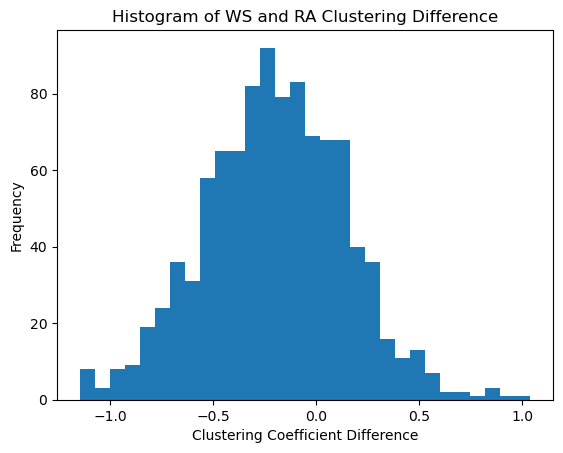

In [126]:
import matplotlib.pyplot as plt

# Plot histograms
plt.hist(clustering_difference, bins=30)

# Labels and title
plt.xlabel('Clustering Coefficient Difference')
plt.ylabel('Frequency')
plt.title('Histogram of WS and RA Clustering Difference')

# Show plot
plt.show()


# Reproduce pairwise small world propensity

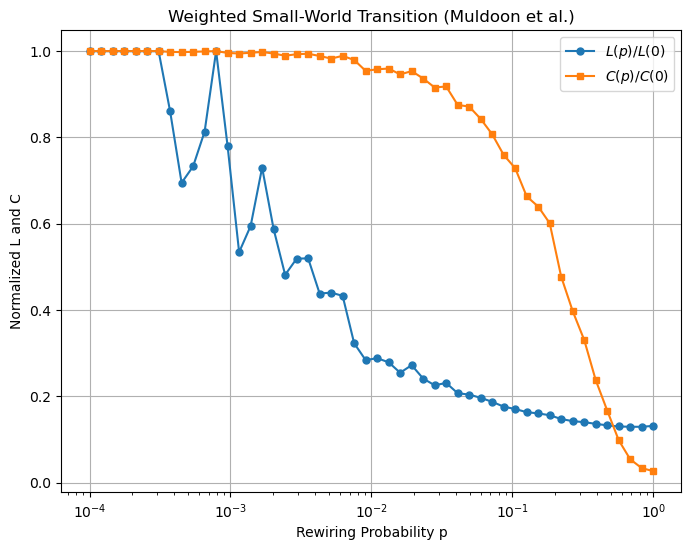

In [60]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def ring_lattice(n, k):
    """ Create a weighted ring lattice where each node is connected to k/2 neighbors on each side. """
    G = nx.Graph()
    for i in range(n):
        for j in range(1, k // 2 + 1):  
            weight1 = np.random.uniform(0.5, 1.5)  # Assign random weights
            weight2 = np.random.uniform(0.5, 1.5)
            G.add_edge(i, (i + j) % n, weight=weight1)
            G.add_edge(i, (i - j) % n, weight=weight2)
    return G

def rewire_graph(G, p):
    """ Rewire edges with probability p while maintaining weights. """
    new_G = G.copy()
    edges = list(G.edges(data=True))  # Extract edges with weights
    nodes = list(G.nodes())

    for u, v, data in edges:
        if np.random.rand() < p:
            new_G.remove_edge(u, v)  # Remove the original edge
            
            while True:
                new_v = np.random.choice(nodes)
                if new_v != u and not new_G.has_edge(u, new_v):
                    new_weight = np.random.uniform(0.5, 1.5)  # Assign new random weight
                    new_G.add_edge(u, new_v, weight=new_weight)
                    break
    return new_G

def random_graph(n, k):
    """ Create a weighted random graph with the same number of nodes and edges. """
    G = nx.gnm_random_graph(n, (n * k) // 2)
    
    for u, v in G.edges():
        G[u][v]['weight'] = np.random.uniform(0.5, 1.5)  # Assign weights
    return G

def compute_L_C(G):
    """ Compute weighted characteristic path length (L) and weighted clustering coefficient (C). """
    # Weighted clustering coefficient using Onnela et al. method (as per Muldoon et al. paper)
    C = np.mean(list(nx.clustering(G, weight="weight").values()))
    
    # Weighted characteristic path length (using Dijkstra's algorithm)
    try:
        L = nx.average_shortest_path_length(G, weight="weight")
    except nx.NetworkXError:
        L = np.nan  # If graph is disconnected, return NaN
    return L, C

# Parameters
n = 500  # Number of nodes
k = 10    # Each node is connected to k/2 neighbors on both sides
p_values = np.logspace(-4, 0, 50)  # Log-spaced p values from 10^-4 to 1

# Compute L(0) and C(0) for the weighted regular lattice
G0 = ring_lattice(n, k)
L0, C0 = compute_L_C(G0)

L_values = []
C_values = []

for p in p_values:
    G = rewire_graph(G0, p)
    L, C = compute_L_C(G)
    L_values.append(L / L0)  # Normalized weighted path length
    C_values.append(C / C0)  # Normalized weighted clustering coefficient

# Set extreme values
C0 = C_observed[0]
C_random = C_observed[-1]
L0 = L_observed[0]
L_random = L_observed[-1]

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(p_values, L_values, 'o-', label=r'$L(p) / L(0)$', markersize=5)
plt.plot(p_values, C_values, 's-', label=r'$C(p) / C(0)$', markersize=5)

# Add horizontal lines for extreme cases
# plt.axhline(y=L_random / L0, color='blue', linestyle='dashed', label=r'$L_{\text{random}} / L(0)$')
# plt.axhline(y=C_random / C0, color='orange', linestyle='dashed', label=r'$C_{\text{random}} / C(0)$')

# Formatting
plt.xscale('log')
plt.xlabel('Rewiring Probability p')
plt.ylabel('Normalized L and C')
plt.title("Weighted Small-World Transition (Muldoon et al.)")
plt.legend()
plt.grid()
plt.show()


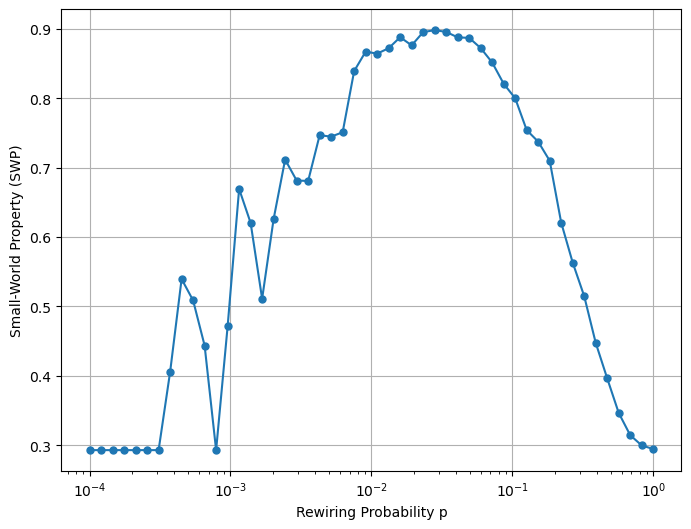

In [61]:
# Compute Small-World Property (SWP) efficiently using NumPy
C_observed = np.array(C_values)
L_observed = np.array(L_values)

dC = (C0 - C_observed) / (C0 - C_random)
dL = (L_observed - L_random) / (L0 - L_random)

SWP_list = 1 - np.sqrt((dC**2 + dL**2) / 2)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(p_values, SWP_list, 'o-', markersize=5)

# Formatting
plt.xscale('log')
plt.xlabel('Rewiring Probability p')
plt.ylabel('Small-World Property (SWP)')
plt.grid()
plt.show()


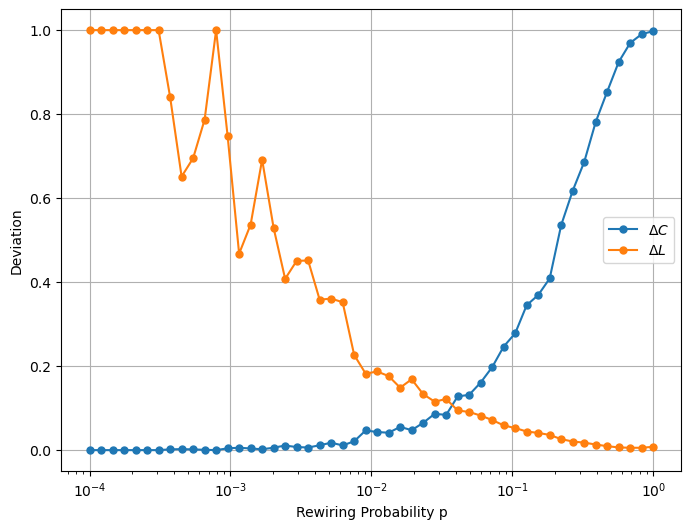

In [62]:
# Plot results
plt.figure(figsize=(8, 6))
plt.plot(p_values, dC, 'o-', label=r'$\Delta C$', markersize=5)
plt.plot(p_values, dL, 'o-', label=r'$\Delta L$', markersize=5)

# Formatting
plt.xscale('log')
plt.xlabel('Rewiring Probability p')
plt.ylabel('Deviation')
plt.legend()
plt.grid()
plt.show()